### Method for Pricing Dual Currency Bonds Using CDS Data: An Example with an Israeli Government Bond

#### Approach:
#### 	1.	CDS-Based Survival Probabilities:
#### 	•	I use the USD-denominated Israel CDS spread curve to derive the survival probabilities of the bond issuer.
#### 	2.	Currency Conversion:
#### 	•	I apply the USDBRL offshore FX rates to convert cash flows into USD.
#### 	3.	Discounting Method:
#### 	•	I use SOFR discounting, where SOFR rates are converted into discount factors.
#### 	4.	Recovery Rate Application:
#### 	•	Finally, I apply the respective recovery rate to the principal cash flow.
####    5.  The result is the dataframe showing raw cashflows and the factors (survival probabilities/DF/FX conversion/recovery) rate applied


### Bond data (Principal BRL / Coupons USD)

<img src="bond.png" alt="My Image" width="1000">

### Israel USD Senior CDS curve

<img src="CDS.png" alt="My Image" width="1000">

### USDBRL Offshore FX rates

<img src="fx.png" alt="My Image" width="700">

### SOFR curve

<img src="SOFR.png" alt="My Image" width="800">

In [1]:
import math
import QuantLib as ql
import pandas as pd

###############################################################################
# 1) INPUTS & CONFIGURATION
###############################################################################
# Valuation and settlement
valuation_date = ql.Date(31, ql.January, 2025)
ql.Settings.instance().evaluationDate = valuation_date

calendar = ql.UnitedStates(ql.UnitedStates.NYSE)  # NYSE holiday calendar (for USD)
settlement_days = 2
settlement_date = calendar.advance(valuation_date, settlement_days, ql.Days)

# Conventions for the bond coupons:
coupon_day_count = ql.Actual360()         # Bond coupon accrual
#coupon_frequency = ql.Semiannual
coupon_frequency = ql.Quarterly
business_convention = ql.Following

# Conventions for discounting / building the yield curve:
discount_day_count = ql.Actual365Fixed()  # OIS discounting day count

# Conventions for CDS premium accrual:
cds_premium_day_count = ql.Actual360()

# Dual-currency bond specifics
annual_coupon_rate = 10.57 / 100
brl_notional = 1_000_000.0

# Bond schedule
issue_date   = ql.Date(13, ql.May, 2024)
first_coupon = ql.Date(17, ql.August, 2024)
maturity_date = ql.Date(17, ql.May, 2028)
maturity_date = calendar.adjust(maturity_date, business_convention)
# Accrued interest references
#prev_coupon_date_for_accrued = ql.Date(30, ql.January, 2025)
next_coupon_date_for_accrued = ql.Date(17, ql.February, 2025)
prev_coupon_date_for_accrued = calendar.advance(next_coupon_date_for_accrued, -int(12/coupon_frequency), ql.Months, ql.Unadjusted)

# CDS market data for Israel (tenor in years, spread in decimal)
cds_data = [
    (0.5,  0.00311),
    (1.00, 0.00415),
    (2.00, 0.00495),
    (3.00, 0.00618),
    (4.00, 0.00731),
    (5.00, 0.00859),
    (7.00, 0.01029),
    (10.0, 0.01200)
]
recovery_rate = 0.25


# SOFR zero rates (time in years, annual rate in decimal, assumed continuous compounding)
sofr_data = [
    (1/52,  0.0437013),
    (2/52,  0.0436926),
    (3/52,  0.0436549),
    (1/12,  0.0436659),
    (2/12,  0.0435379),
    (0.25,  0.0434058),
    (0.50,  0.0426837),
    (7/12,  0.0424399),
    (8/12,  0.0422007),
    (9/12,  0.0419983),
    (10/12, 0.0417828),
    (11/12, 0.0415780),
    (1.00,  0.0414019),
    (1.50,  0.0406376),
    (2.00,  0.0402413),
    (3.00,  0.0399973),
    (4.00,  0.0400064),
    (5.00,  0.0400806),
]

# USD/BRL offshore forward curve (time in years, BRL per 1 USD)
fx_forwards = [
    (0.00,    5.84435),
    (1.0/52,  5.852048),
    (1.0/12,  5.874825),
    (2.0/12,  5.914332),
    (3.0/12,  5.942819),
    (6.0/12,  6.075151),
    (9.0/12,  6.222571),
    (12.0/12, 6.366907),
    (18.0/12, 6.649033),
    (2.0,     6.92925),
    (3.0,     7.517462),
    (4.0,     8.128882),
    (5.0,     8.790709),
    (7.0,     10.321838),
    (10.0,    12.851164),
]

###############################################################################
# 2) BUILD THE USD RISK-FREE DISCOUNT CURVE (ACT/365) FROM SOFR DATA
###############################################################################
dates = [valuation_date]
dfs   = [1.0]

for (t, r) in sofr_data:
    # Convert 't' (in years) to an actual date
    ndays = int(round(t * 365))
    dt = calendar.advance(valuation_date, ndays, ql.Days)

    # Time fraction for discounting
    tau = discount_day_count.yearFraction(valuation_date, dt)

    # Continuous compounding discount factor
    df = math.exp(-r * tau)

    dates.append(dt)
    dfs.append(df)

risk_free_curve = ql.DiscountCurve(dates, dfs, discount_day_count)
risk_free_curve.enableExtrapolation()



###############################################################################
# 3) CALIBRATE THE CDS HAZARD RATE (SURVIVAL PROBABILITY) CURVE
###############################################################################
cds_helpers = []
for tenor, spread in cds_data:
    period_months = int(round(tenor * 12))
    period = ql.Period(period_months, ql.Months)

    helper = ql.SpreadCdsHelper(
        ql.QuoteHandle(ql.SimpleQuote(spread)),
        period,
        settlement_days,
        calendar,
        ql.Quarterly,
        business_convention,
        ql.DateGeneration.CDS,
        cds_premium_day_count,            # ← use ACT/360 for premium accrual
        recovery_rate,
        ql.YieldTermStructureHandle(risk_free_curve),  # discount curve (ACT/365)
        True,  # settlesAccrual
        True,  # paysAtDefaultTime
        ql.Date(),  # startDate
        cds_premium_day_count,            # lastPeriodDayCounter
        True,  # rebatesAccrual
        ql.CreditDefaultSwap.ISDA
    )
    cds_helpers.append(helper)

hazard_curve = ql.PiecewiseFlatHazardRate(
    valuation_date,
    cds_helpers,
    discount_day_count  # build hazard curve referencing ACT/365 discount
)
hazard_curve.enableExtrapolation()

def survival_probability_date(dt):
    """Return the survival probability at date dt from the calibrated hazard curve."""
    return hazard_curve.survivalProbability(dt, True)

###############################################################################
# 4) BUILD THE FX FORWARD (BRL->USD) CONVERSION CURVE
###############################################################################
fx_times = [pt[0] for pt in fx_forwards]
fx_rates = [pt[1] for pt in fx_forwards]
fx_interp = ql.LinearInterpolation(fx_times, fx_rates)


# Build FX forward curve using log-linear interpolation
fx_times = [pt[0] for pt in fx_forwards]
fx_rates = [pt[1] for pt in fx_forwards]
fx_interp = ql.LogLinearInterpolation(fx_times, fx_rates)

def conversion_factor_date(dt):
    """
    Interpolate the FX forward rate using log-linear interpolation.
    Then return the conversion factor as 1 / (interpolated FX rate).
    """
    t = ql.Actual365Fixed().yearFraction(valuation_date, dt)
    # Use flat extrapolation if t is outside the provided range:
    if t <= fx_times[0]:
        fx_rate = fx_rates[0]
    elif t >= fx_times[-1]:
        fx_rate = fx_rates[-1]
    else:
        fx_rate = fx_interp(t, True)
    return 1.0 / fx_rate

###############################################################################
# 5) BUILD THE BOND COUPON SCHEDULE
###############################################################################
schedule = ql.Schedule(
    first_coupon,
    maturity_date,
    ql.Period(coupon_frequency),
    calendar,
    business_convention,
    business_convention,
    ql.DateGeneration.Forward,
    False
)
coupon_dates = list(schedule)


def accrual_year_fraction(d1, d2):
    """Use ACT/360 for the bond coupon accrual."""
    return coupon_day_count.yearFraction(d1, d2)

###############################################################################
# 6) BUILD THE CASH-FLOW TABLE & PRICE THE BOND
###############################################################################
table_data = {
    "PaymentDate": [],
    "FlowType": [],
    "DayFraction": [],
    "SurvivalProb": [],
    "RiskFreeDF": [],
    "ConvFactor(USD/BRL)": [],
    "Coupon(BRL)": [],
    "ExpectedFlow(USD)": []
}

dirty_price = 0.0
previous_coupon_date = prev_coupon_date_for_accrued

for cDate in coupon_dates:
    if cDate <= valuation_date:
        continue  # skip past flows

    dcf = accrual_year_fraction(previous_coupon_date, cDate)
    sp  = survival_probability_date(cDate)
    df_ = risk_free_curve.discount(cDate)
    conv = conversion_factor_date(cDate)

    # Periodic coupon in BRL
    coupon_brl = annual_coupon_rate * dcf * brl_notional
    coupon_usd = coupon_brl * df_ * sp * conv
    dirty_price += coupon_usd

    # Populate the table
    table_data["PaymentDate"].append(cDate.ISO())
    table_data["FlowType"].append("Coupon")
    table_data["DayFraction"].append(round(dcf, 5))
    table_data["SurvivalProb"].append(round(sp, 6))
    table_data["RiskFreeDF"].append(round(df_, 6))
    table_data["ConvFactor(USD/BRL)"].append(round(conv, 6))
    table_data["Coupon(BRL)"].append(round(coupon_brl, 2))
    table_data["ExpectedFlow(USD)"].append(round(coupon_usd, 2))

    previous_coupon_date = cDate

# Principal redemption at maturity
S_T = survival_probability_date(maturity_date)
df_maturity = risk_free_curve.discount(maturity_date)
conv_maturity = conversion_factor_date(maturity_date)
expected_principal_brl = brl_notional * (S_T + (1 - S_T) * recovery_rate)
principal_usd = expected_principal_brl * df_maturity * conv_maturity
dirty_price += principal_usd

table_data["PaymentDate"].append(maturity_date.ISO())
table_data["FlowType"].append("Principal")
table_data["DayFraction"].append(0.0)
table_data["SurvivalProb"].append(round(S_T, 6))
table_data["RiskFreeDF"].append(round(df_maturity, 6))
table_data["ConvFactor(USD/BRL)"].append(round(conv_maturity, 6))
table_data["Coupon(BRL)"].append(0.0)
table_data["ExpectedFlow(USD)"].append(round(principal_usd, 2))

###############################################################################
# 7) COMPUTE ACCRUED INTEREST & CLEAN PRICE
###############################################################################
accrued_usd = 0.0

if prev_coupon_date_for_accrued < valuation_date < next_coupon_date_for_accrued:
    full_period = accrual_year_fraction(prev_coupon_date_for_accrued, next_coupon_date_for_accrued)
    accrued_period = accrual_year_fraction(prev_coupon_date_for_accrued, valuation_date)

    full_coupon_brl = annual_coupon_rate * full_period * brl_notional
    accrued_brl = full_coupon_brl * (accrued_period / full_period)
    accrued_usd = accrued_brl * risk_free_curve.discount(valuation_date) * conversion_factor_date(valuation_date)

clean_price = dirty_price - accrued_usd

###############################################################################
# 8) OUTPUT RESULTS
###############################################################################
df = pd.DataFrame(table_data)
print("Cash Flow Table:")
#print(df.to_string(index=False))

print("\nBond Pricing Results (USD):")
print(f"  Dirty Price: {dirty_price:,.2f}")
print(f"  Accrued Interest: {accrued_usd:,.2f}")
print(f"  Clean Price: {clean_price:,.2f}")


spot_fx = fx_forwards[0][1]  # immediate spot from your list
print(f"\nAdditional Conversions:")
print(f"  Dirty Price in BRL = {dirty_price * spot_fx/1000000*100:,.2f}")
print(f"  Clean Price in BRL = {clean_price * spot_fx/1000000*100:,.2f}")
df

Cash Flow Table:

Bond Pricing Results (USD):
  Dirty Price: 163,401.24
  Accrued Interest: 3,767.88
  Clean Price: 159,633.36

Additional Conversions:
  Dirty Price in BRL = 95.50
  Clean Price in BRL = 93.30


,PaymentDate,FlowType,DayFraction,SurvivalProb,RiskFreeDF,ConvFactor(USD/BRL),Coupon(BRL),ExpectedFlow(USD)
0,2025-02-18,Coupon,0.25833,0.999794,0.997848,0.170569,27305.83,4646.55
1,2025-05-19,Coupon,0.25000,0.998764,0.987221,0.167591,26425.00,4366.61
2,2025-08-18,Coupon,0.25278,0.997724,0.976872,0.163893,26718.61,4267.97
3,2025-11-17,Coupon,0.25278,0.996191,0.966773,0.160050,26718.61,4118.49
4,2026-02-17,Coupon,0.25556,0.994317,0.956925,0.156429,27012.22,4020.50
5,2026-05-18,Coupon,0.25000,0.992413,0.947567,0.153120,26425.00,3804.95
6,2026-08-17,Coupon,0.25278,0.990451,0.938318,0.149871,26718.61,3721.48
7,2026-11-17,Coupon,0.25556,0.988472,0.929114,0.146785,27012.22,3641.45
8,2027-02-17,Coupon,0.25556,0.986496,0.920000,0.143769,27012.22,3524.60
9,2027-05-17,Coupon,0.24722,0.983966,0.911275,0.140941,26131.39,3302.40


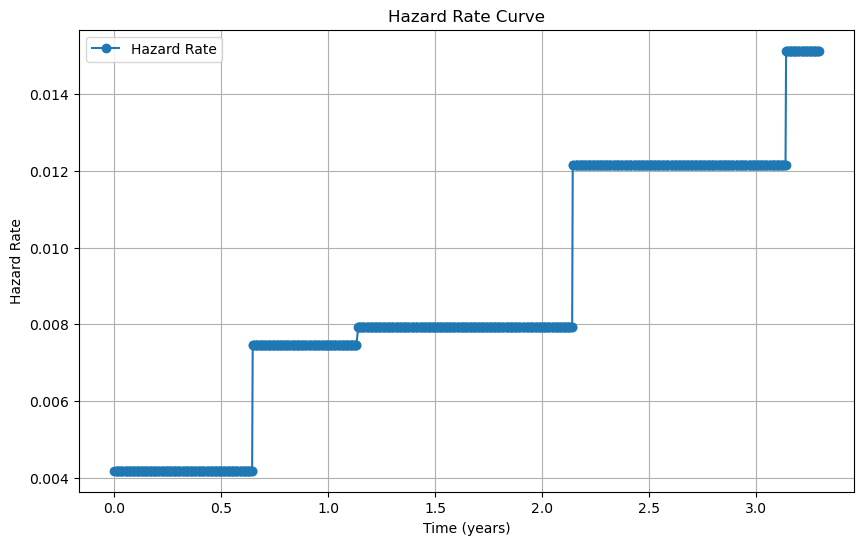

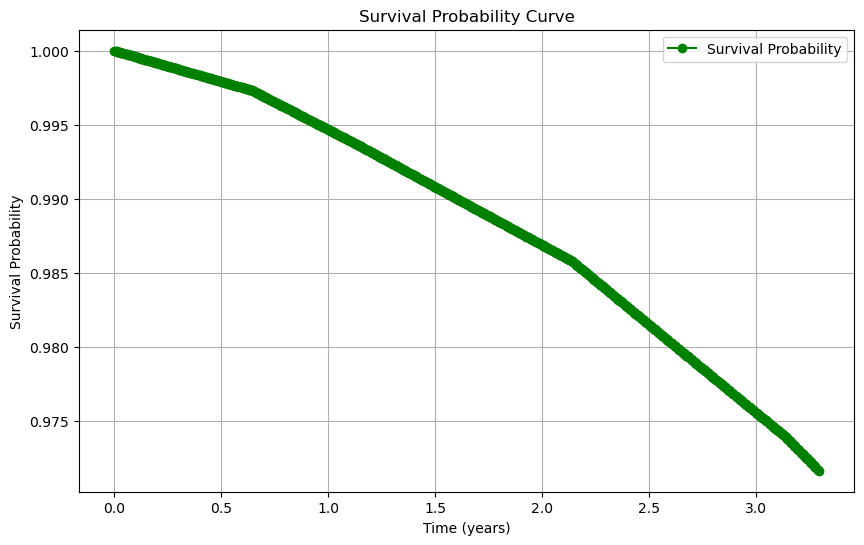

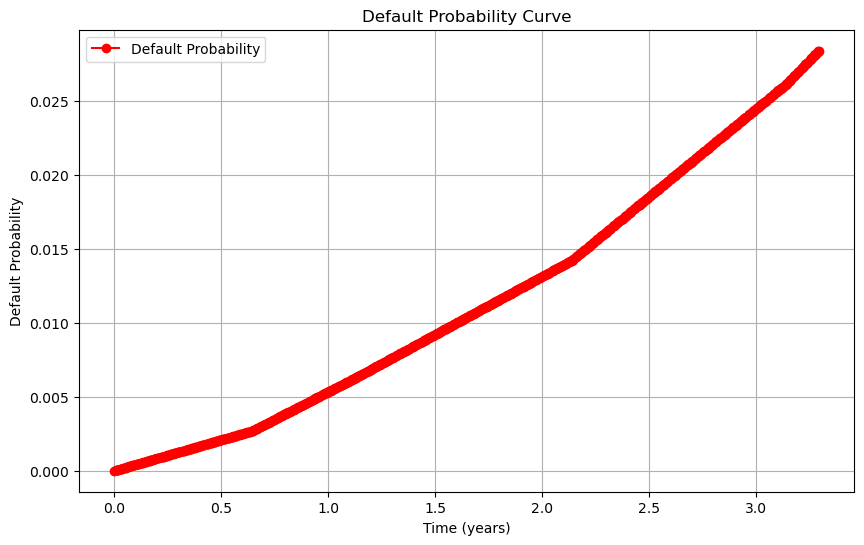

In [5]:
import matplotlib.pyplot as plt

# ------------------------------------------------------------------
# 9) PLOT THE HAZARD RATE, SURVIVAL PROBABILITY, AND DEFAULT PROBABILITY CURVES
# ------------------------------------------------------------------

# Initialize lists to store time (in years) and corresponding curve values.
time_points = []
hazard_rates = []
survival_probs = []
default_probs = []

# Loop from the valuation_date until the maturity_date (advance by 6 months each step)
current_date = valuation_date
while current_date <= maturity_date:
    # Compute time (in years) from valuation_date to current_date
    t = discount_day_count.yearFraction(valuation_date, current_date)
    time_points.append(t)
    
    # Retrieve the hazard rate at current_date. 'True' enables extrapolation.
    hazard = hazard_curve.hazardRate(current_date, True)
    hazard_rates.append(hazard)
    
    # Get survival probability at current_date
    surv = hazard_curve.survivalProbability(current_date, True)
    survival_probs.append(surv)
    
    # Default probability is simply 1 - survival probability.
    default_probs.append(1.0 - surv)
    
    # Advance current_date by 6 months
    #current_date = calendar.advance(current_date, 6, ql.Months)
    current_date = calendar.advance(current_date, 1, ql.Days)

# Plot the Hazard Rate Curve
plt.figure(figsize=(10, 6))
plt.plot(time_points, hazard_rates, marker='o', linestyle='-', label='Hazard Rate')
plt.title("Hazard Rate Curve")
plt.xlabel("Time (years)")
plt.ylabel("Hazard Rate")
plt.grid(True)
plt.legend()
plt.show()

# Plot the Survival Probability Curve
plt.figure(figsize=(10, 6))
plt.plot(time_points, survival_probs, marker='o', linestyle='-', color='green', label='Survival Probability')
plt.title("Survival Probability Curve")
plt.xlabel("Time (years)")
plt.ylabel("Survival Probability")
plt.grid(True)
plt.legend()
plt.show()

# Plot the Default Probability Curve
plt.figure(figsize=(10, 6))
plt.plot(time_points, default_probs, marker='o', linestyle='-', color='red', label='Default Probability')
plt.title("Default Probability Curve")
plt.xlabel("Time (years)")
plt.ylabel("Default Probability")
plt.grid(True)
plt.legend()
plt.show()

In [3]:
for helper in cds_helpers:
    print(helper.latestDate().ISO())
    t_node = discount_day_count.yearFraction(valuation_date, helper.latestDate())
    print(f"Year fraction: {t_node:.4f}")

2025-09-23
Year fraction: 0.6438
2026-03-21
Year fraction: 1.1342
2027-03-23
Year fraction: 2.1397
2028-03-21
Year fraction: 3.1370
2029-03-21
Year fraction: 4.1370
2030-03-21
Year fraction: 5.1370
2032-03-23
Year fraction: 7.1452
2035-03-21
Year fraction: 10.1397
